# ECO5050 Assignment 1 Solution

We will replicate the empirical example in Lecture 3 slides, based on Welch and Goyal (2008).

Some of the code is borrowed from the source below: \
https://github.com/yniu87/EquityPremium/blob/master/312_Predicting_equity_premium.ipynb

The data are downloaded from Amit Goyal's website: \
https://sites.google.com/view/agoyal145






In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import warnings
import seaborn as sns
import itertools
warnings.simplefilter("ignore", UserWarning)

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

## Packages that you actually don't need for this assignment
#from sklearn.model_selection import TimeSeriesSplit
# from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
# from sklearn.model_selection import RepeatedKFold, KFold, StratifiedKFold, RepeatedStratifiedKFold
# from sklearn.model_selection import cross_val_score, GridSearchCV, PredefinedSplit, TimeSeriesSplit


In [3]:
# Import data
df = pd.read_excel("Welch_Goyal_PredictorData2023.xlsx", sheet_name='Quarterly')
df.tail(10)

,yyyyq,Index,D12,E12,b/m,tbl,AAA,BAA,lty,cay,...,infl,ltr,corpr,svar,csp,ik,CRSP_SPvw,CRSP_SPvwx,D3,E3
602,20213,4307.54,59.254483,175.37,0.188541,0.0004,0.0253,0.0323,0.0137,-0.069219,...,0.009621,0.001221,-0.000482,0.003120,NaN,0.033512,0.007009,0.003535,15.359000,49.59
603,20214,4766.18,60.397117,197.87,0.175599,0.0006,0.0265,0.0330,0.0147,-0.052766,...,0.016376,0.014919,0.012221,0.004996,NaN,0.033451,0.108956,0.105195,15.783466,53.94
604,20221,4530.41,61.969974,197.91,0.206653,0.0044,0.0343,0.0429,0.0213,-0.043082,...,0.031212,-0.055753,-0.076871,0.011203,NaN,0.034024,-0.045115,-0.048560,16.250101,45.99
605,20222,3785.38,64.019605,192.26,0.232861,0.0149,0.0424,0.0527,0.0314,-0.028864,...,0.030633,-0.037749,-0.072570,0.019890,NaN,0.034158,-0.161792,-0.165304,16.627038,42.74
606,20223,3585.62,65.318305,187.08,0.249478,0.0313,0.0459,0.0569,0.0352,-0.027858,...,0.001677,-0.043479,-0.050566,0.011470,NaN,0.034241,-0.046349,-0.050490,16.657700,44.41
607,20224,3839.50,66.922828,172.75,0.216199,0.0425,0.0443,0.0559,0.0362,-0.020875,...,-0.000037,0.007221,0.036339,0.015548,NaN,0.034075,0.071819,0.067163,17.387989,39.61
608,20231,4109.31,68.211442,175.17,0.220060,0.0469,0.0460,0.0571,0.0366,-0.020240,...,0.016978,0.030049,0.035021,0.006916,NaN,0.034243,0.076900,0.072284,17.538715,48.41
609,20232,4450.38,68.714936,181.01,0.212811,0.0516,0.0465,0.0575,0.0375,-0.018591,...,0.010844,-0.013775,-0.002851,0.003512,NaN,0.034544,0.088719,0.084395,17.130532,48.58
610,20233,4288.05,69.313136,184.25,0.218528,0.0532,0.0513,0.0616,0.0438,-0.012995,...,0.008784,-0.030606,-0.030927,0.002897,NaN,0.034341,-0.032530,-0.036230,17.255900,47.65
611,20234,4769.83,70.303692,192.43,0.194280,0.0524,0.0474,0.0564,0.0402,-0.008255,...,-0.003389,0.056625,0.085022,0.003816,NaN,0.034337,0.116225,0.111510,18.378545,47.79


We will use 11 variables as predictors:

log divididend-price ratio (dp), log dividend yield (dy), log earnings-price ratio (ep), book-to-market ratio (bm), net equity issues (ntis), three-month T-bill rate (tbl), long term returns (ltr), term spread (tms), default yield (dfy), inflation (infl), investment-capital ratio (ik)

Some predictors need to be generated from raw data.

In [4]:
# equity premium, i.e., the total rate of return on the stock market minus the prevailing short-term interest rate.
df['premium'] = df['CRSP_SPvw'] - df['Rfree']

# Dividend Price Ratio (d/p) is the difference between the log of dividends and the log of prices. 
df['dp'] = np.log(df['D12']) - np.log(df['Index'])

# Dividend Yield (d/y) is the difference between the log of dividends and the log of lagged prices.
df['dy'] = np.log(df['D12'])- np.log(df['Index'].shift(1))

# Earnings Price Ratio (e/p) is the difference between the log of earnings and the log of prices.
df['ep'] = np.log(df['E12']) - np.log(df['Index'])

# Term Spread (tms) is the difference between the long term yield on government bonds and the T-bill.
df['tms'] = df['lty'] - df['tbl']

# Default Yield Spread (dfy): is the difference between BAA- and AAA- rated cor- porate bond yields.
df['dfy'] = df['BAA'] - df['AAA']

# Rename 'b/m' to 'bm'
df = df.rename(columns={'b/m':'bm'})

# List of predictors names
x_names = ['dp', 'dy', 'ep','bm', 'ntis', 'tbl', 'ltr', 'tms', 'dfy', 'infl', 'ik']


# Create a 'date' column from 'year' and 'quarter'
df['year'] = df['yyyyq'].astype(str).str[:4].astype(int)  # Extract the year
df['quarter'] = df['yyyyq'].astype(str).str[4].astype(int)  # Extract the quarter
df['date'] = pd.PeriodIndex(year=df['year'], quarter=df['quarter'], freq='Q')


Pick the predictors and lag them by one quarter. Concatenate with the stock return we want to forecast, 'premium'. Drop rows if any variable has null values. Now the dataframe starts in 1947Q1 and ends in 2023Q4. 

Note that the predictor variables are lagged, so the predictors are from 1947Q1-2023Q3, and stock return from 1947Q2-2023Q4,

Also, normalize the X variables so that it has mean 0 and variance 1.

We generate pseudo out-of-sample forecasts using a recursively expanding estimation window.

In [5]:
# Lag the predictors and drop rows if any of the variables has null values
df_clean = pd.concat([df[['date', 'premium']], df[x_names].shift(1)], axis=1 )
df_clean = df_clean.dropna(axis=0)

### Question 1

Generate pseudo out-of-sample forecasts with a recursively expanding estimation window, using all 11 predictors. The first forecast uses data up to 1969Q4 to estimates model (1) by OLS, and generate a forecast of stock returns for 1970Q1. The second forecast uses data up to 1970Q1 and generate a forecast for 1970Q2. This procedure continues sequentially up to 2023Q4. Plot the forecasts with the actual stock return values and the benchmark model forecasts. Compute the out-of-sample MSE and compare with the MSE of the benchmark model forecasts.


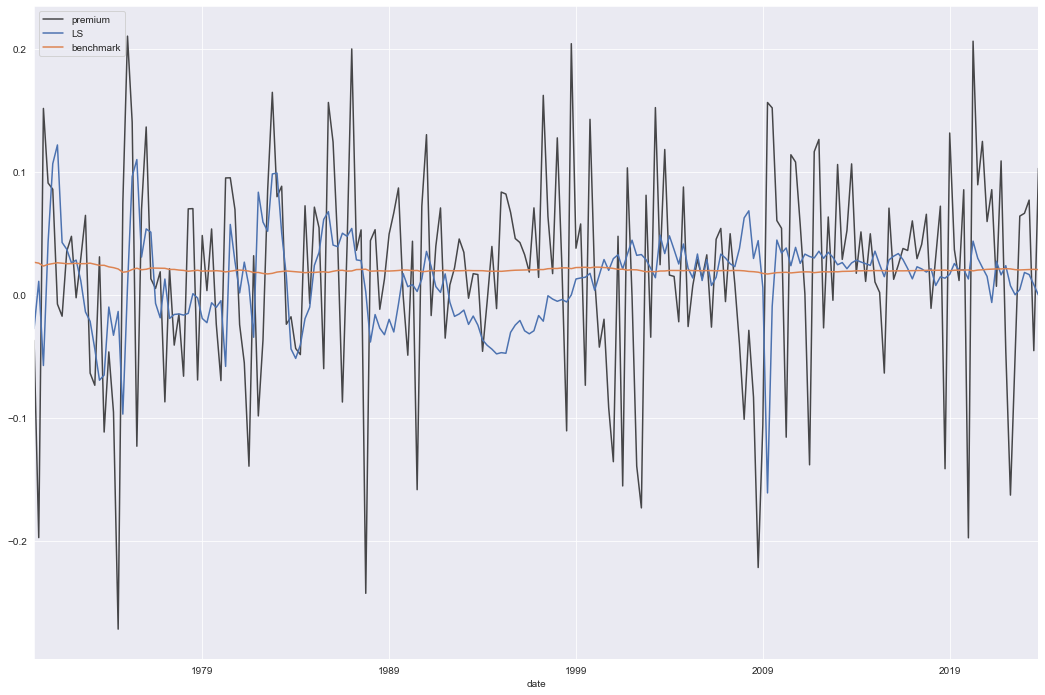

In [8]:
# Set initial start and end points for training data based on X variables
initial_train_end = '1969Q4'
final_train_end = '2023Q3'

forecasts = []


# Recursive Forecasting with Expanding Window
for current_date in pd.period_range(start=initial_train_end, end=final_train_end, freq='Q'):
    
    # current_date starts at 1969Q4. Note that df_clean[x_names] is already lagged
    # y_train: data from 1947Q2 to current_date quarter
    # X_train: data from 1947Q1 to current_date - 1 quarter
    X_train = df_clean.loc[df_clean['date'] <= current_date, x_names]
    y_train = df_clean.loc[df_clean['date'] <= current_date, 'premium']
    
    
    # Train model with selected features
    X_train_window = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_window).fit()
    
    # Forecast one quarter ahead, using the test sample not used in estimation
    # df_clean contains lagged X
    forecast_date = current_date + 1
    X_test = df_clean.loc[df_clean['date'] == forecast_date, x_names]

    # Manually add the constant column (intercept) because X_test has one row
    X_test_selected = X_test.copy()
    X_test_selected.insert(0, 'const', 1)  
    
    # Benchmark: prevailing mean
    benchmark = y_train.mean()    

    forecast = model.predict(X_test_selected)
    forecasts.append({'date': forecast_date, 'LS': forecast.iloc[0], 'benchmark': benchmark})
    
    
    
forecast_df = pd.DataFrame(forecasts)

# Actual stock return values
forecast_df['premium'] = df_clean.loc[df_clean['date'] > initial_train_end, ['premium']].reset_index(drop=True)

# Display the forecast results
forecast_df.set_index('date', inplace=True)
forecast_df.sort_index(inplace=True)

with sns.color_palette('deep'):
    fig, axes = plt.subplots(1, figsize=(18, 12))
    
    forecast_df['premium'].plot(ax=axes, color='k', alpha=0.7)
    forecast_df.iloc[:,:2].plot(ax=axes)
    axes.legend()


In [9]:
mse_ls = mean_squared_error(forecast_df['LS'],forecast_df['premium'])
mse_benchmark= mean_squared_error(forecast_df['benchmark'],forecast_df['premium'])

print(f'OLS out-of-sample forecast MSE: {mse_ls}')
print(f'Benchmark out-of-sample forecast MSE: {mse_benchmark}')

OLS out-of-sample forecast MSE: 0.008116961540453401
Benchmark out-of-sample forecast MSE: 0.007025864348749509


The benchmark model (prevailing mean) generates forecasts that has a smaller out-of-sample MSE. The plot shows that the benchmark forecasts does not change much over time, whereas the OLS forecasts varies across time.

Note that Table 6.2 in Lecture 3 slides (Elliott and Timmermann 2016) provides the RMSE in %. We can simply take the square root of MSE and multiply 100.

In [10]:
rmse_ls_per = 100*np.sqrt(mse_ls)
rmse_benchmark_per = 100*np.sqrt(mse_benchmark)

print(f'OLS out-of-sample forecast RMSE(%): {rmse_ls_per}')
print(f'Benchmark out-of-sample forecast RMSE(%): {rmse_benchmark_per}')

OLS out-of-sample forecast RMSE(%): 9.009418150165638
Benchmark out-of-sample forecast RMSE(%): 8.382042918495173


## Question 2

Use the last expanding window that ends at 2023Q3, as the estimation sample (training set) for the following model selection methods. Consider all possible $2^{11}$ linear forecast models in (1). For each of the model selection methods write down the selected predictors and the stock return forecast for 2023Q4. 


Note: For AIC and BIC, compute the criteria using the formulas for linear regressions, introduced in Lecture 2 slides. For Lasso, standardize the predictor variables to have mean 0 and variance 1 before applying the method.

In [11]:
current_date = '2023Q3'
forecast_date = '2023Q4'

X_train = df_clean.loc[df_clean['date'] <= current_date, x_names]
y_train = df_clean.loc[df_clean['date'] <= current_date, 'premium']

X_test = df_clean.loc[df_clean['date'] == forecast_date, x_names]
y_test = df_clean.loc[df_clean['date'] == forecast_date, 'premium']

# Dataframe for forecasts and squared error for all methods
method_list = ['AIC', 'BIC', 'Lasso', 'CV', 'Forward Stepwise']
forecast_23Q4 = pd.DataFrame([], columns = ['Actual', 'Forecast'], index=method_list)

### (a) AIC

In [12]:
# Function that computes the values of the AIC and BIC criteria

def compute_aic_bic(model):
    # Get the number of observations and number of parameters
    T = model.nobs  
    k = model.df_model + 1  # Number of estimated parameters (including intercept)
    
    # Compute the sum of squared residuals (SSR)
    ssr = np.sum(model.resid ** 2)
    
    # Compute AIC
    aic = np.log(ssr / T) + 2*k/T
    
    # Compute BIC
    bic = np.log(ssr / T) + np.log(T)*k/T
    
    return aic, bic

In [13]:
criterion = 'AIC'

best_score = np.inf  # Initialize best score to a very large number
best_model = None
best_selected_x = None

# Iterate over all combinations of predictors
for i in range(1, len(x_names) + 1):
    for combo in itertools.combinations(x_names, i):
        # Train model for the current combination of features
        X_train_selected = sm.add_constant(X_train[list(combo)])
        model = sm.OLS(y_train, X_train_selected).fit()
        
        # Compute AIC or BIC
        aic, bic = compute_aic_bic(model)

        # Use the chosen criterion
        score = aic if criterion == 'AIC' else bic

        # Check if this is the best model based on the chosen criterion
        if score < best_score:
            best_score = score
            best_model = model
            best_selected_x = list(combo)
            

                
X_test_selected = X_test[best_selected_x].copy()
X_test_selected.insert(0, 'const', 1)
forecast_aic = best_model.predict(X_test_selected)
forecast_23Q4.loc['AIC', 'Forecast'] = forecast_aic.iloc[0]

# Save the list of predictors selected by AIC for question 4
aic_selected_x = best_selected_x

In [14]:
## AIC
print(f'Predictors selected by AIC: {best_selected_x}')
print(f'AIC forecast: {forecast_aic.iloc[0]}, Actual value: {y_test.iloc[0]}')
print(f'AIC squared error: {(forecast_aic.iloc[0]-y_test.iloc[0])**2}')

Predictors selected by AIC: ['dy', 'tbl', 'ltr', 'ik']
AIC forecast: -0.004859603072862484, Actual value: 0.10292511095098442
AIC squared error: 0.011617544577202458


### (b) BIC

In [15]:
criterion = 'BIC'


best_score = np.inf  # Initialize best score to a very large number
best_model = None
best_selected_x = None

# Iterate over all combinations of predictors
for i in range(1, len(x_names) + 1):
    for combo in itertools.combinations(x_names, i):
        # Train model for the current combination of features
        X_train_selected = sm.add_constant(X_train[list(combo)])
        model = sm.OLS(y_train, X_train_selected).fit()
        
        # Compute AIC or BIC
        aic, bic = compute_aic_bic(model)

        # Use the chosen criterion
        score = aic if criterion == 'AIC' else bic

        # Check if this is the best model based on the chosen criterion
        if score < best_score:
            best_score = score
            best_model = model
            best_selected_x = list(combo)
            

                
# Manually add the constant column (intercept) because X_test has one row
X_test_selected = X_test[best_selected_x].copy()
X_test_selected.insert(0, 'const', 1)
forecast_bic = best_model.predict(X_test_selected)

forecast_23Q4.loc['BIC', 'Forecast'] = forecast_bic.iloc[0]

In [16]:
## BIC
print(f'Predictors selected by BIC: {best_selected_x}')
print(f'BIC forecast: {forecast_bic.iloc[0]}, Actual value: {y_test.iloc[0]}')
print(f'BIC squared error: {(forecast_bic.iloc[0]-y_test.iloc[0])**2}')

Predictors selected by BIC: ['ltr', 'ik']
BIC forecast: 0.018330304115093732, Actual value: 0.10292511095098442
BIC squared error: 0.007156281343601657


### (c) Lasso with penalty parameter 0.005

In [17]:
def best_lasso_model_simple(X_train, y_train, penalty):
    """
    Finds the best Lasso model using a penalty 
    
    Parameters:
    X_train (DataFrame): Training data (predictors).
    y_train (Series): Variable to forecast (Target variable).
    
    Returns:
    dict: A dictionary containing the best Lasso model and selected predictor variables
    """

    # Step 1: Standardize the predictors (Lasso is sensitive to scaling)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Step 2: Fit the Lasso model with the computed penalty (alpha parameter in Lasso)
    lasso_model = Lasso(alpha=penalty, fit_intercept=True, max_iter=10000)
    lasso_model.fit(X_train_scaled, y_train)
    
    # Step 4: Get the selected features
    selected_features = X_train.columns[lasso_model.coef_ != 0].tolist()
    
    return {
        'best_model': lasso_model,
        'best_selected_x': selected_features
    }

In [18]:
best_lasso_info = best_lasso_model_simple(X_train, y_train, 0.005)

best_selected_x = best_lasso_info['best_selected_x']
best_model = best_lasso_info['best_model']
X_test_selected = X_test.copy()
forecast_lasso = best_model.predict(X_test_selected)

forecast_23Q4.loc['Lasso', 'Forecast'] = forecast_lasso[0]

print(f'Predictors selected by Lasso: {best_selected_x}')
print(f'Lasso forecast: {forecast_lasso[0]}, Actual value: {y_test.iloc[0]}')
print(f'Lasso squared error: {(forecast_lasso[0]-y_test.iloc[0])**2}')

Predictors selected by Lasso: ['dy', 'tbl', 'ltr', 'infl', 'ik']
Lasso forecast: 0.006864204341455541, Actual value: 0.10292511095098442
Lasso squared error: 0.009227697778644628


### (d) $v$-block cross-validation

Be aware that $v$-block cross-validation is different from the $K$-fold cross-validation. You cannot use the KFold command, and the default method for cross_val_score is KFold.

As far as I know you have to manually program the $v$-block cross-validation, i.e., leave $T_v$ out cross validation for serially correlated data.


In [19]:
def leave_Tv_out_cross_validation(X, y):
    """
    Performs Leave-Tv-out cross-validation and selects the combination of variables that minimizes MSE.
    
    Parameters:
    X (DataFrame): Predictor variables.
    y (Series): Target variable.
    
    Returns:
    dict: A dictionary containing the best model and selected features
    """
    T = len(y)  # Total number of observations in training data
    v = math.floor(0.5*(0.5*T-np.sqrt(T)-1)/2)
    
    # Block (validation set) size
    Tv = 2 * v + 1  
    n_splits = T - Tv  # Number of possible splits
    
    best_mse = np.inf  # Initialize best MSE to infinity
    best_selected_x = None
    best_model = None

    # Iterate over all combinations of predictors
    predictors = X.columns
    for i in range(1, len(predictors) + 1):
        for combo in itertools.combinations(predictors, i):
            # Store the MSE for each split for the current combination of predictors
            mse_list = []
            
            # Perform leave-Tv-out cross-validation for the current predictor combination
            for split_point in range(n_splits):
                # Define the validation set (from split_point to split_point + block_size)
                val_start = split_point
                val_end = split_point + Tv
                
                X_combo = X[list(combo)]
                # Training and validation sets
                X_train = pd.concat([X_combo.iloc[:val_start, :], X_combo.iloc[val_end:, :]])
                y_train = pd.concat([y.iloc[:val_start], y.iloc[val_end:]])
                X_val = X_combo.iloc[val_start:val_end, :]
                y_val = y.iloc[val_start:val_end]
                
                # Fit the model on the training data
                X_train_selected = sm.add_constant(X_train)
                model = sm.OLS(y_train, X_train_selected).fit()
                
                # Predict on the validation set
                X_val_selected = sm.add_constant(X_val)
                y_pred = model.predict(X_val_selected)
                
                # Compute MSE for the current split
                mse = mean_squared_error(y_val, y_pred)
                mse_list.append(mse)
            
            # Compute the average MSE for this combination of predictors
            avg_mse = np.mean(mse_list)
            
            # If the average MSE is better than the best MSE, store the model
            if avg_mse < best_mse:
                best_mse = avg_mse
                best_selected_x = list(combo)
                best_model = model

    # Return the best model and relevant information
    return {
        'best_model': best_model,
        'best_selected_x': best_selected_x
    }

In [20]:
best_cv_info = leave_Tv_out_cross_validation(X_train, y_train)
best_selected_x = best_cv_info['best_selected_x']
best_model = best_cv_info['best_model']

X_test_selected = X_test[best_selected_x].copy()
X_test_selected.insert(0, 'const', 1)
forecast_cv = best_model.predict(X_test_selected)

forecast_23Q4.loc['CV', 'Forecast'] = forecast_cv.iloc[0]

print(f'Predictors selected by CV: {best_selected_x}')
print(f'CV forecast: {forecast_cv.iloc[0]}, Actual value: {y_test.iloc[0]}')
print(f'CV squared error: {(forecast_cv.iloc[0]-y_test.iloc[0])**2}')

KeyboardInterrupt: 

### (e) Forward stepwise with maximum p-value 0.05

In [26]:
def forward_stepwise(X, y, max_p_value=0.05):
    selected_features = []
    remaining_features = list(X.columns)
    
    # Initial step: Find the first predictor with the lowest p-value
    while remaining_features:
        pvals = []
        # Evaluate each remaining X variables individually
        for feature in remaining_features:
            X_temp = sm.add_constant(X[[feature]])
            model = sm.OLS(y, X_temp).fit()
            pvals.append((model.pvalues[feature], feature))
        
        # Find feature with smallest p-value; sort by p-value
        pvals.sort() 
        current_p_value, best_feature = pvals[0]
        
        # If the p-value is less than max_p_value (0.05), add it to the model
        if current_p_value < max_p_value:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            # Fit model with the selected feature
            X_selected = sm.add_constant(X[selected_features])
            best_model = sm.OLS(y, X_selected).fit()
            break  # Break out after adding the first feature
        else:
            # No valid predictors found
            return selected_features, best_model
    
    # Subsequent steps: Add one feature at a time to the baseline model
    while remaining_features:
        pvals = []
        for feature in remaining_features:
            X_temp = sm.add_constant(X[selected_features + [feature]])
            model = sm.OLS(y, X_temp).fit()
            pvals.append((model.pvalues[feature], feature))
        
        # Find the feature with the smallest p-value when added to the model
        pvals.sort()
        current_p_value, best_feature = pvals[0]
        
        # If the p-value is below the threshold, add the feature to the model
        if current_p_value < max_p_value:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            # Refit the model with the new set of selected features
            X_selected = sm.add_constant(X[selected_features])
            best_model = sm.OLS(y, X_selected).fit()
        else:
            break  # Stop when no more features can improve the model
    
    return selected_features, best_model


In [27]:
forward_selected_x, forward_model = forward_stepwise(X_train, y_train, max_p_value=0.05)

X_test_selected = X_test[forward_selected_x].copy()
X_test_selected.insert(0, 'const', 1)
forecast_forward = forward_model.predict(X_test_selected)

forecast_23Q4.loc['Forward Stepwise','Forecast'] = forecast_forward.iloc[0]

print(f'Predictors selected by Forward Stepwise: {forward_selected_x}')
print(f'Forward Stepwise forecast: {forecast_forward.iloc[0]}, Actual value: {y_test.iloc[0]}')
print(f'Forward Stepwise squared error: {(forecast_cv.iloc[0]-y_test.iloc[0])**2}')


Predictors selected by Forward Stepwise: ['ik', 'ltr']
Forward Stepwise forecast: 0.01833030411509376, Actual value: 0.10292511095098442
Forward Stepwise squared error: 0.014726015856997048


## Question 3

In Question 2, which method selects the ``best" model in forecasting the stock return in 2023Q4?

In [28]:
forecast_23Q4['Actual'] = y_test.iloc[0]
forecast_23Q4['MSE'] = (forecast_23Q4['Actual']-forecast_23Q4['Forecast'])**2

In [29]:
forecast_23Q4.astype(float).round(5)

,Actual,Forecast,MSE
AIC,0.10293,-0.00486,0.01162
BIC,0.10293,0.01833,0.00716
Lasso,0.10293,0.00686,0.00923
CV,0.10293,-0.01843,0.01473
Forward Stepwise,0.10293,0.01833,0.00716


BIC and Forward stepwise achieves the minimum squared error 0.00716. This is the MSE for the out-of-sample with one observation. BIC and Forward stepwise selects predictors 'ik' (investment-capital ratio) and 'ltr' (long term returns).

## Question 4

This is a simple exercise to reduce computation time. Suppose that the only predictors you observe are the variables that were selected by AIC in 2(a). Now use the $v$-block cross-validation ($v$ from 2(d)) and recursively expanding window to generate out-of-sample stock return forecasts for 1990Q1-2023Q4. Plot the forecasts with the actual stock return values and the benckmark model forecasts. Compute the out-of-sample MSE and compare with the MSE of the benchmark model forecasts. (If the calculation takes too long, you can shorten the out-of-sample forecast period.)


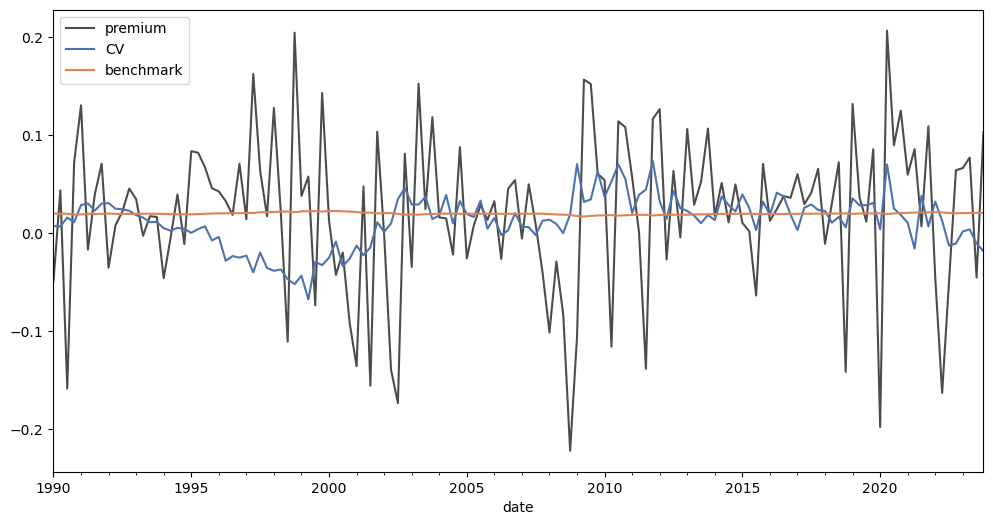

In [32]:
# Set initial start and end points for training data based on X variables
initial_train_end = '1989Q4'
final_train_end = '2023Q3'

forecasts = []


# Recursive Forecasting with Expanding Window
for current_date in pd.period_range(start=initial_train_end, end=final_train_end, freq='Q'):
    
    # Restrict our search to the predictors selected by AIC in (a)
    X_train = df_clean.loc[df_clean['date'] <= current_date, aic_selected_x]
    y_train = df_clean.loc[df_clean['date'] <= current_date, 'premium']
    
    best_cv_info = leave_Tv_out_cross_validation(X_train, y_train)
    best_selected_x = best_cv_info['best_selected_x']
    best_model = best_cv_info['best_model']

    
    # Forecast one quarter ahead using the variables selected by CV
    forecast_date = current_date + 1
    X_test = df_clean.loc[df_clean['date'] == forecast_date, best_selected_x]

    # Manually add the constant column (intercept) because X_test has one row
    X_test_selected = X_test.copy()
    X_test_selected.insert(0, 'const', 1)  

    # Benchmark: prevailing mean
    benchmark = y_train.mean()    
    
    forecast = best_model.predict(X_test_selected)
    forecasts.append({'date': forecast_date, 'CV': forecast.iloc[0], 'benchmark': benchmark})
    
    
    
forecast_df = pd.DataFrame(forecasts)

# Actual stock return values
forecast_df['premium'] = df_clean.loc[df_clean['date'] > initial_train_end, ['premium']].reset_index(drop=True)

# Display the forecast results
forecast_df.set_index('date', inplace=True)
forecast_df.sort_index(inplace=True)

with sns.color_palette('deep'):
    fig, axes = plt.subplots(1, figsize=(12, 6))
    
    forecast_df['premium'].plot(ax=axes, color='k', alpha=0.7)
    forecast_df.iloc[:,:2].plot(ax=axes)
    axes.legend()


In [31]:
mse_cv = mean_squared_error(forecast_df['CV'],forecast_df['premium'])
mse_benchmark= mean_squared_error(forecast_df['benchmark'],forecast_df['premium'])

print(f'Cross-validation out-of-sample forecast MSE: {mse_ls}')
print(f'Benchmark out-of-sample forecast MSE: {mse_benchmark}')

Cross-validation out-of-sample forecast MSE: 0.008116961540453405
Benchmark out-of-sample forecast MSE: 0.005885259778889231
